In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
from pathlib import Path

In [2]:
%matplotlib inline

Text(0.5,1,'Undistorted')

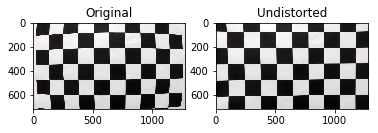

In [3]:
if Path('./calibration.p').exists():
    with open('./calibration.p', 'rb') as handle:
        calibration = pickle.load(handle)
        ret = calibration['ret']
        mtx = calibration['mtx']
        dist = calibration['dist']
        rvecs = calibration['rvecs']
        tvecs = calibration['tvecs']
else:
    cal_images = glob.glob('./camera_cal/*.jpg')

    nx = 9
    ny = 6

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    obj_points = []
    image_points = []

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for image_path in cal_images:
        img = cv2.imread(image_path) # read in BGR mode
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corner = cv2.findChessboardCorners(gray,(nx,ny))

        if ret is True:
            obj_points.append(objp)
            corner2 = cv2.cornerSubPix(gray, corner, (11, 11), (-1, -1), criteria)
            cv2.drawChessboardCorners(img, (nx,ny),corner2,ret)
            image_points.append(corner2)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, gray.shape[::-1],None,None)

    calibration={}
    calibration['ret'] = ret
    calibration['mtx'] = mtx
    calibration['dist'] = dist
    calibration['rvecs'] = rvecs
    calibration['tvecs'] = tvecs
    with open('./calibration.p', 'wb') as handle:
        pickle.dump(calibration, handle)
        
img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(dst[:,:,::-1])
plt.title('Undistorted')

In [4]:
def abs_sobel_thresh(img_channel, orient='x', ksize=3, thresh=(0, 255)):
    if orient is 'x':
        direction = [1, 0]
    elif orient is 'y':
        direction = [0, 1]
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, direction[0], direction[1],ksize=ksize)
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [5]:
def mag_thresh(img_channel, ksize=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

In [6]:
def dir_threshold(img_channel, ksize=3, thresh=(0, np.pi / 2)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

In [7]:
def color_threshold(img_channel, thresh=(0, 255)):
    binary_output = np.zeros_like(img_channel)
    binary_output[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary_output

Text(0.5,1,'Undistorted')

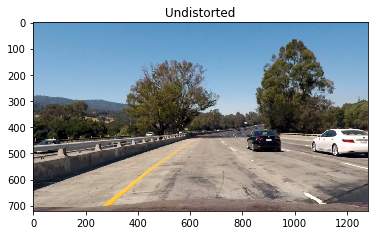

In [8]:
img = cv2.imread('./test_images/test1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure()
plt.subplot(1, 1, 1)
plt.imshow(dst[:,:,::-1])
plt.title('Undistorted')

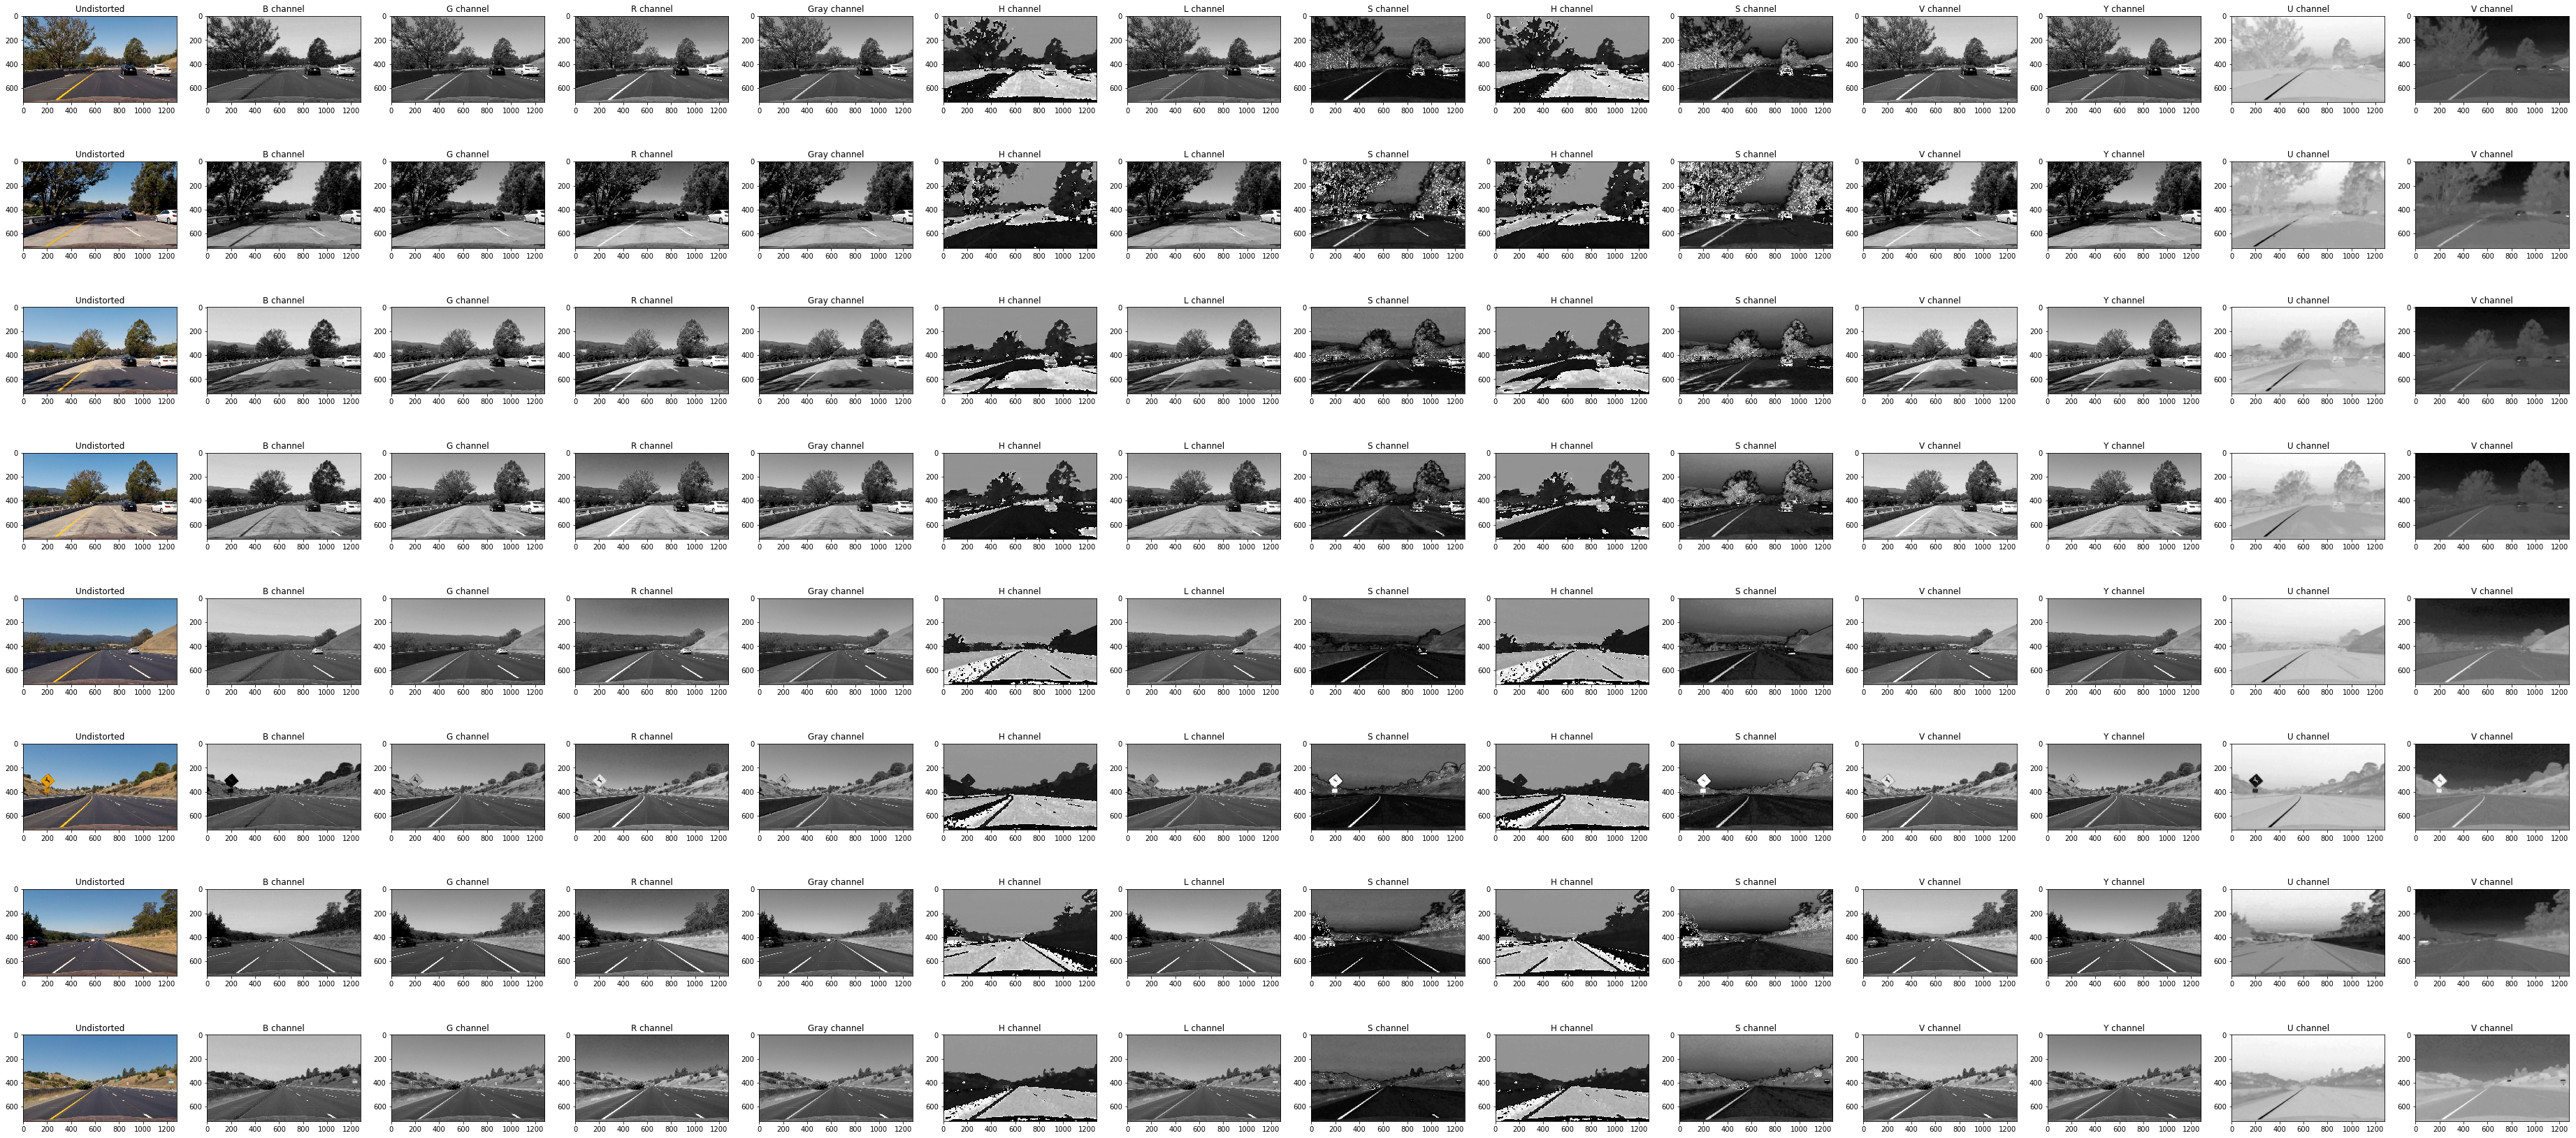

In [8]:
# choose a proper color channel
test_images = glob.glob('./test_images/*.jpg')
test_num = len(test_images)

plt.figure(figsize=(70,30))
fig_num = 15

for idx, image_path in zip(range(test_num), test_images):
    # original image
    img = cv2.imread(image_path)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(test_num, fig_num, idx*fig_num+1)
    plt.imshow(dst[:,:,::-1])
    plt.title('Undistorted')

    #BGR channels
    plt.subplot(test_num, fig_num, idx*fig_num+2)
    plt.imshow(dst[:,:,0],cmap='gray')
    plt.title('B channel')
    plt.subplot(test_num, fig_num, idx*fig_num+3)
    plt.imshow(dst[:,:,1],cmap='gray')
    plt.title('G channel')
    plt.subplot(test_num, fig_num, idx*fig_num+4)
    plt.imshow(dst[:,:,2],cmap='gray')
    plt.title('R channel')

    # gray channel
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    plt.subplot(test_num, fig_num, idx*fig_num+5)
    plt.imshow(gray,cmap='gray')
    plt.title('Gray channel')

    # HLS channels
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    plt.subplot(test_num, fig_num, idx*fig_num+6)
    plt.imshow(hls[:,:,0],cmap='gray')
    plt.title('H channel')
    plt.subplot(test_num, fig_num, idx*fig_num+7)
    plt.imshow(hls[:,:,1],cmap='gray')
    plt.title('L channel')
    plt.subplot(test_num, fig_num, idx*fig_num+8)
    plt.imshow(hls[:,:,2],cmap='gray')
    plt.title('S channel')

    # HSV channels
    hsv = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
    plt.subplot(test_num, fig_num, idx*fig_num+9)
    plt.imshow(hsv[:,:,0],cmap='gray')
    plt.title('H channel')
    plt.subplot(test_num, fig_num, idx*fig_num+10)
    plt.imshow(hsv[:,:,1],cmap='gray')
    plt.title('S channel')
    plt.subplot(test_num, fig_num, idx*fig_num+11)
    plt.imshow(hsv[:,:,2],cmap='gray')
    plt.title('V channel')

    # YUV channels
    yuv = cv2.cvtColor(dst, cv2.COLOR_BGR2YUV)
    plt.subplot(test_num, fig_num, idx*fig_num+12)
    plt.imshow(yuv[:,:,0],cmap='gray')
    plt.title('Y channel')
    plt.subplot(test_num, fig_num, idx*fig_num+13)
    plt.imshow(yuv[:,:,1],cmap='gray')
    plt.title('U channel')
    plt.subplot(test_num, fig_num, idx*fig_num+14)
    plt.imshow(yuv[:,:,2],cmap='gray')
    plt.title('V channel')

(1280, 720)


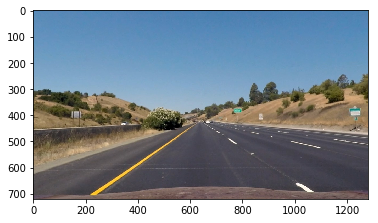

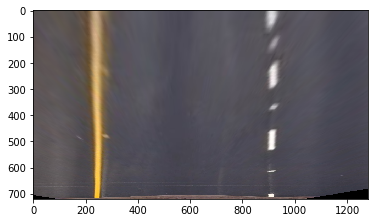

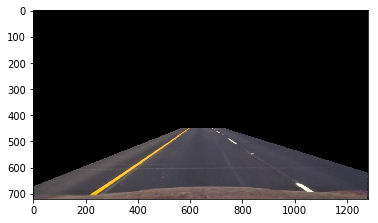

In [9]:
# test for calculate perspective matrix - correct
perspective_images = cv2.imread('./test_images/straight_lines1.jpg')
perspective_src = cv2.undistort(perspective_images, mtx, dist, None, mtx)
plt.figure()
plt.imshow(perspective_src[:,:,::-1])

src_region = np.float32([[441,560], [849,560], [215,719], [1090,719]])
dst_region = np.float32([[250,630], [900,630], [250,719], [900,719]])
dsize = perspective_src.shape[0:2][::-1]
print(dsize)

M = cv2.getPerspectiveTransform(src_region, dst_region)
inv_M = cv2.getPerspectiveTransform(dst_region, src_region)
after_perspective = cv2.warpPerspective(perspective_src, M, dsize, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(after_perspective[:,:,::-1])
inv_perspective = cv2.warpPerspective(after_perspective, inv_M, dsize, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(inv_perspective[:,:,::-1])

perspective={}
perspective['M'] = M
perspective['inv_M'] = inv_M
with open('./perspective.p', 'wb') as handle:
    pickle.dump(perspective, handle)

(1280, 720)
[[-5.25558358e-01 -1.34072048e+00  9.00102467e+02]
 [-1.42108547e-14 -1.89213722e+00  8.51766812e+02]
 [-2.12503626e-17 -2.37480168e-03  1.00000000e+00]]


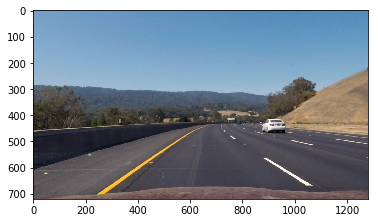

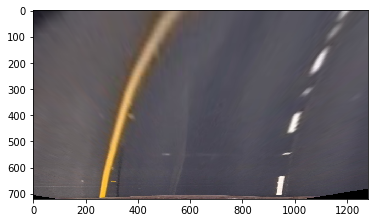

In [10]:
# test for calculate perspective matrix - correct
perspective_images = cv2.imread('./test_images/test3.jpg')
perspective_src = cv2.undistort(perspective_images, mtx, dist, None, mtx)
plt.figure()
plt.imshow(perspective_src[:,:,::-1])

src_region = np.float32([[441,560], [849,560], [215,719], [1090,719]])
dst_region = np.float32([[250,630], [900,630], [250,719], [900,719]])
dsize = perspective_src.shape[0:2][::-1]
print(dsize)
# dsize = (250,250)

M = cv2.getPerspectiveTransform(src_region, dst_region)
print(M)
after_perspective = cv2.warpPerspective(perspective_src, M, dsize, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(after_perspective[:,:,::-1])

[[-5.29406631e-01 -1.34759521e+00  9.04577687e+02]
 [-6.83897383e-14 -1.82505987e+00  7.99813515e+02]
 [-9.97465999e-17 -2.38200664e-03  1.00000000e+00]]


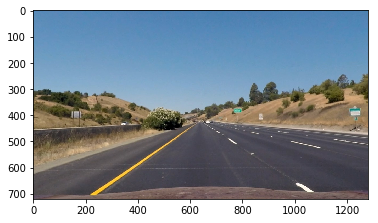

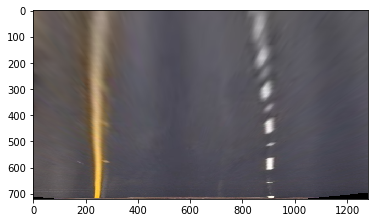

In [11]:
# test for calculate perspective matrix - incorrect
perspective_images = cv2.imread('./test_images/straight_lines1.jpg')
perspective_src = cv2.undistort(perspective_images, mtx, dist, None, mtx)
plt.figure()
plt.imshow(perspective_src[:,:,::-1])

src_region = np.float32([[573,467], [711,467], [215,719], [1090,719]])
dst_region = np.float32([[250,467], [900,467], [250,719], [900,719]])
dsize = perspective_src.shape[0:2][::-1]


M = cv2.getPerspectiveTransform(src_region, dst_region)
print(M)
after_perspective = cv2.warpPerspective(perspective_src, M, dsize, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(after_perspective[:,:,::-1])

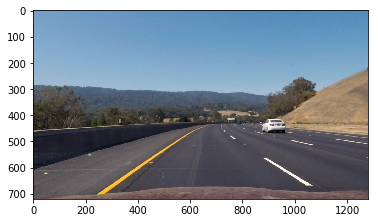

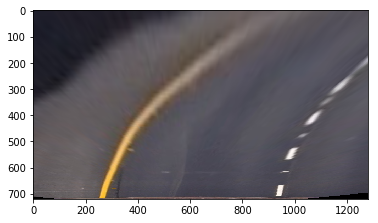

In [12]:
# test for calculate perspective matrix - incorrect
perspective_images = cv2.imread('./test_images/test3.jpg')
perspective_src = cv2.undistort(perspective_images, mtx, dist, None, mtx)
plt.figure()
plt.imshow(perspective_src[:,:,::-1])

src_region = np.float32([[573,467], [711,467], [215,719], [1090,719]])
dst_region = np.float32([[250,467], [900,467], [250,719], [900,719]])
dsize = perspective_src.shape[0:2][::-1]


M = cv2.getPerspectiveTransform(src_region, dst_region)
after_perspective = cv2.warpPerspective(perspective_src, M, dsize, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(after_perspective[:,:,::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test_add.jpg, left_curverad: 270.81 m, right_curverad: 273.40 m


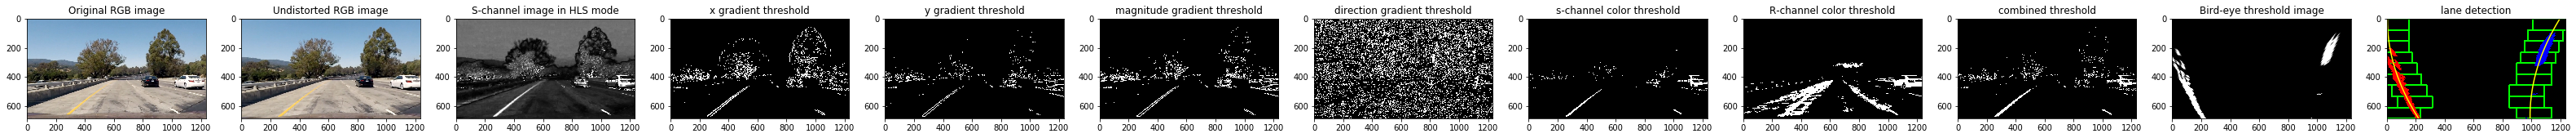

In [20]:
# pipeline for single test image
image_path = './test_images/test_add.jpg'
test_num = 1
fig_num = 15
plt.figure(figsize=(70,30))
idx=0

if Path('./perspective.p').exists():
    with open('./perspective.p', 'rb') as handle:
        perspective = pickle.load(handle)
        M = perspective['M']
        inv_M = perspective['inv_M']
else:
    print('calculate perspective matrix first')

# original image
img = cv2.imread(image_path)
plt.subplot(test_num, fig_num, idx*fig_num+1)
plt.imshow(img[:,:,::-1])
plt.title('Original RGB image')

# distorted image
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(test_num, fig_num, idx*fig_num+2)
plt.imshow(dst[:,:,::-1])
plt.title('Undistorted RGB image')

# select s channel in HLS mode
hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
s_channel = hls[:, :, 2]
plt.subplot(test_num, fig_num, idx*fig_num+3)
plt.imshow(s_channel,cmap='gray')
plt.title('S-channel image in HLS mode')

# x gradient threshold
sobel_mask_x = abs_sobel_thresh(s_channel, 'x', ksize=7,thresh=(25,200))
plt.subplot(test_num, fig_num, idx*fig_num+4)
plt.imshow(sobel_mask_x, cmap='gray')
plt.title('x gradient threshold')
# y gradient threshold
sobel_mask_y = abs_sobel_thresh(s_channel, 'y',ksize=7, thresh=(50,150))
plt.subplot(test_num, fig_num, idx*fig_num+5)
plt.imshow(sobel_mask_y, cmap='gray')
plt.title('y gradient threshold')
# magnitude gradient threshold
mag_mask = mag_thresh(s_channel, ksize=7, mag_thresh=(50,200))
plt.subplot(test_num, fig_num, idx*fig_num+6)
plt.imshow(mag_mask, cmap='gray')
plt.title('magnitude gradient threshold')
# direction gradient threshold
dir_mask = dir_threshold(s_channel, ksize=7, thresh=(-0.5, 0.5))
plt.subplot(test_num, fig_num, idx*fig_num+7)
plt.imshow(dir_mask, cmap='gray')
plt.title('direction gradient threshold')

# s-channel color threshold
s_color_mask = color_threshold(s_channel, thresh=(180,255))
plt.subplot(test_num, fig_num, idx*fig_num+8)
plt.imshow(s_color_mask, cmap='gray')
plt.title('s-channel color threshold')

# R-channel color threshold
r_color_mask = color_threshold(dst[:,:,2], thresh=(200,255))
plt.subplot(test_num, fig_num, idx*fig_num+9)
plt.imshow(r_color_mask, cmap='gray')
plt.title('R-channel color threshold')

# combined gradient threshold
combined = np.zeros_like(dir_mask)
combined[(((sobel_mask_x == 1) & (sobel_mask_y == 1)) | ((mag_mask == 1) & (dir_mask == 1))) | ((s_color_mask == 1)& (r_color_mask == 1))] = 1

plt.subplot(test_num, fig_num, idx*fig_num+10)
plt.imshow(combined, cmap='gray')
plt.title('combined threshold')

# perspective transform
dsize = combined.shape[0:2][::-1]
after_perspective = cv2.warpPerspective(combined, M, dsize, flags=cv2.INTER_LINEAR)
plt.subplot(test_num, fig_num, idx*fig_num+11)
plt.imshow(after_perspective, cmap='gray')
plt.title('Bird-eye threshold image')

# find the lines using HOG
# Take a histogram of the bottom half of the image
histogram = np.sum(after_perspective[after_perspective.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((after_perspective, after_perspective, after_perspective))*255
# plot windows       
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(after_perspective.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = after_perspective.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 120
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = after_perspective.shape[0] - (window+1)*window_height
    win_y_high = after_perspective.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    out_img = cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 10)
    out_img = cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 10) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))      

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, after_perspective.shape[0]-1, after_perspective.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.subplot(test_num, fig_num, idx*fig_num+12)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title('lane detection')
plt.xlim(0, out_img.shape[1])
plt.ylim(out_img.shape[0], 0)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 3/80 # meters per pixel in y dimension
xm_per_pix = 3.7/662 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('image: %s, left_curverad: %.2f m, right_curverad: %.2f m'%(image_path.split('/')[-1], left_curverad, right_curverad))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test6.jpg, left_curverad: 685.29 m, right_curverad: 534.43 m, offset: -0.12 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test5.jpg, left_curverad: 720.49 m, right_curverad: 245.49 m, offset: -0.37 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test4.jpg, left_curverad: 628.59 m, right_curverad: 347.15 m, offset: -0.06 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test1.jpg, left_curverad: 290.43 m, right_curverad: 274.74 m, offset: -0.14 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test3.jpg, left_curverad: 343.34 m, right_curverad: 418.71 m, offset: -0.21 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: test2.jpg, left_curverad: 291.93 m, right_curverad: 231.44 m, offset: -0.03 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: straight_lines2.jpg, left_curverad: 1129.68 m, right_curverad: 3140.37 m, offset: -0.35 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: straight_lines1.jpg, left_curverad: 5407.88 m, right_curverad: 970.09 m, offset: -0.38 m


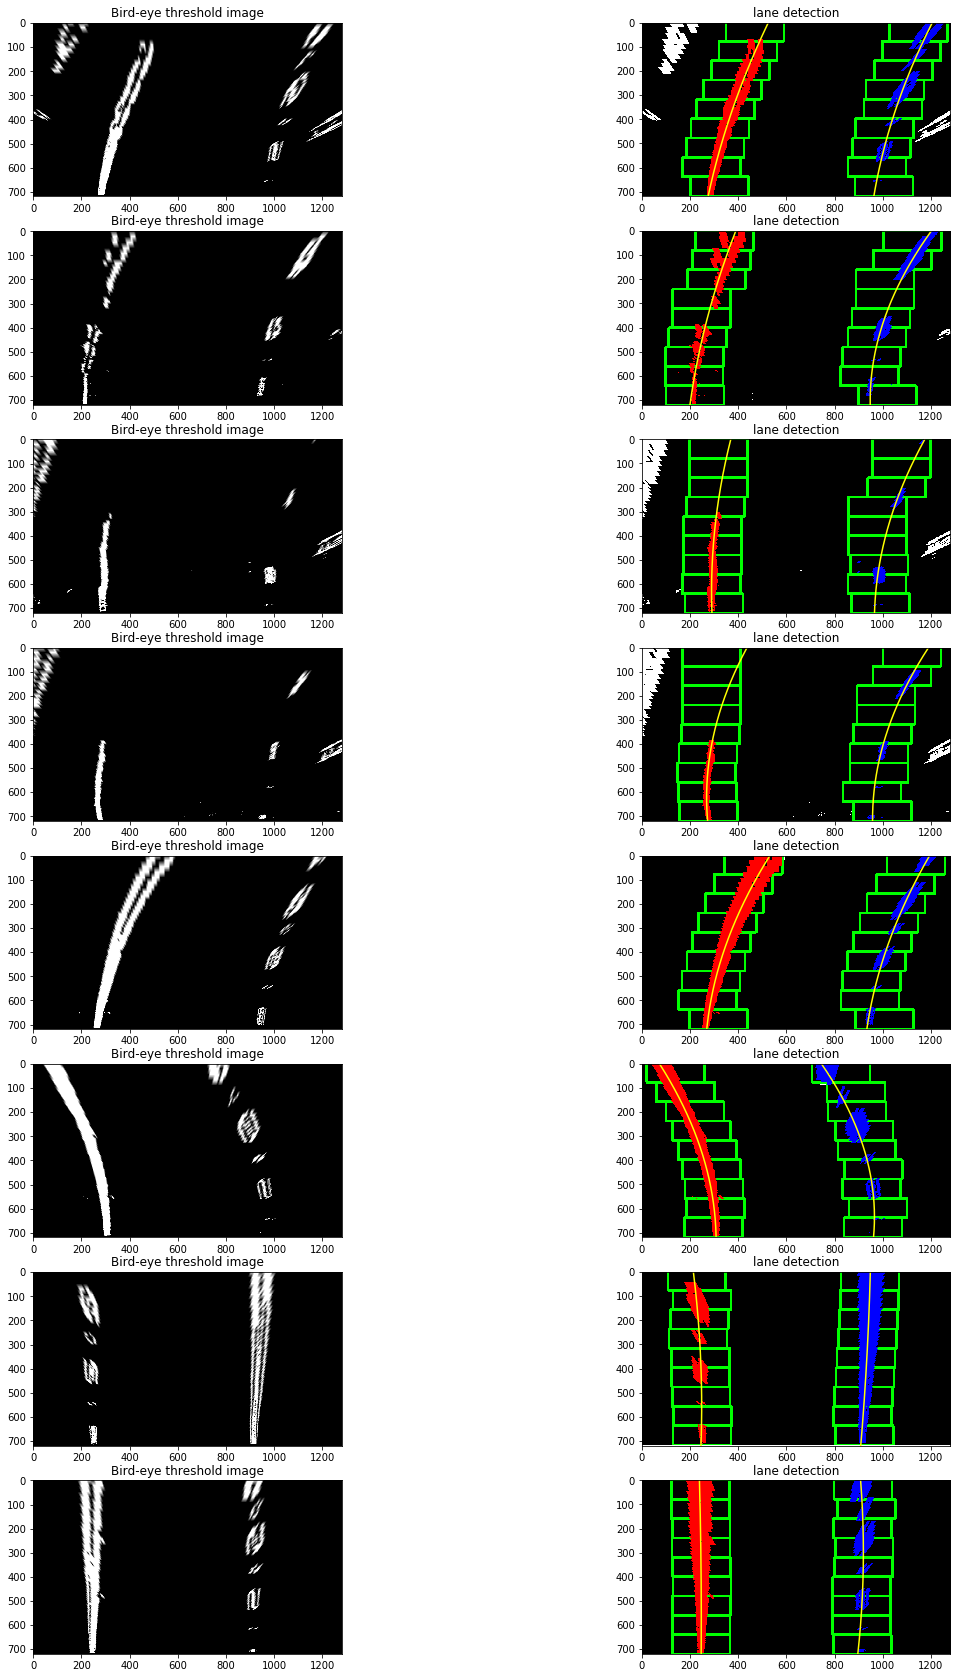

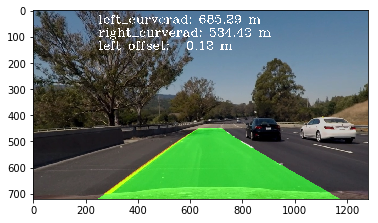

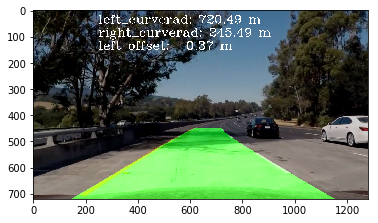

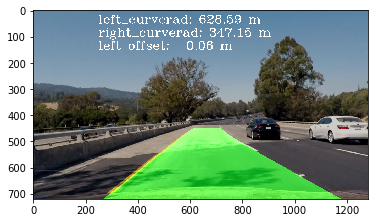

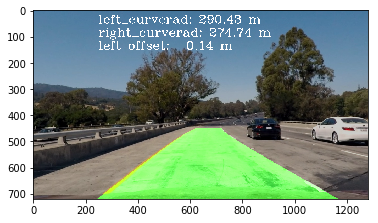

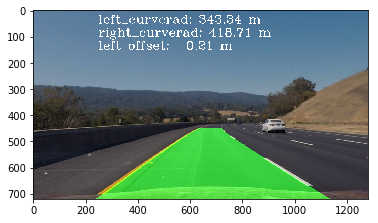

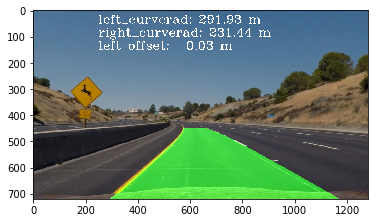

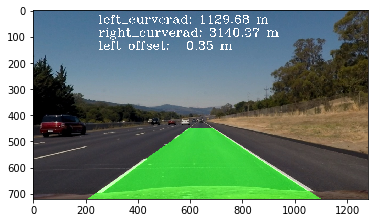

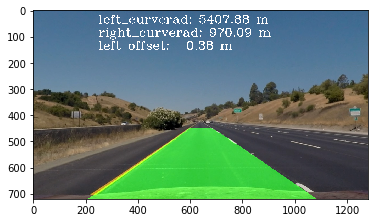

In [47]:
# pipeline for test images
test_images = glob.glob('./test_images/*.jpg')
test_num = len(test_images)

fig1 = plt.figure(figsize=(70,30))
fig_num = 12

if Path('./calibration.p').exists():
    with open('./calibration.p', 'rb') as handle:
        calibration = pickle.load(handle)
        ret = calibration['ret']
        mtx = calibration['mtx']
        dist = calibration['dist']
        rvecs = calibration['rvecs']
        tvecs = calibration['tvecs']
else:
    print('calibrate camera first')
    
if Path('./perspective.p').exists():
    with open('./perspective.p', 'rb') as handle:
        perspective = pickle.load(handle)
        M = perspective['M']
        inv_M = perspective['inv_M']
else:
    print('calculate perspective matrix first')

for idx, image_path in zip(range(test_num), test_images):
    # original image
    img = cv2.imread(image_path)
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+1)
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original RGB image')

    # distorted image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+2)
    ax1.imshow(dst[:,:,::-1])
    ax1.set_title('Undistorted RGB image')

    # r channel
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+3)
    r_channel = dst[:,:,2]
    ax1.imshow(r_channel,cmap='gray')
    ax1.set_title('R channel image')

    # x gradient threshold
    sobel_mask_x = abs_sobel_thresh(r_channel, 'x', ksize=7,thresh=(25,200))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+4)
    ax1.imshow(sobel_mask_x, cmap='gray')
    ax1.set_title('x gradient threshold')
    # y gradient threshold
    sobel_mask_y = abs_sobel_thresh(r_channel, 'y',ksize=7, thresh=(50,150))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+5)
    ax1.imshow(sobel_mask_y, cmap='gray')
    ax1.set_title('y gradient threshold')
    # magnitude gradient threshold
    mag_mask = mag_thresh(r_channel, ksize=7, mag_thresh=(50,200))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+6)
    ax1.imshow(mag_mask, cmap='gray')
    ax1.set_title('magnitude gradient threshold')
    # direction gradient threshold
    dir_mask = dir_threshold(r_channel, ksize=7, thresh=(-0.5, 0.5))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+7)
    ax1.imshow(dir_mask, cmap='gray')
    ax1.set_title('direction gradient threshold')

    # s-channel color threshold
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_color_mask = color_threshold(s_channel, thresh=(180,255))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+8)
    ax1.imshow(s_color_mask, cmap='gray')
    ax1.set_title('s-channel color threshold')

    # R-channel color threshold
    r_color_mask = color_threshold(dst[:,:,2], thresh=(200,255))
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+9)
    ax1.imshow(r_color_mask, cmap='gray')
    ax1.set_title('R-channel color threshold')

    # combined gradient threshold
    combined = np.zeros_like(dir_mask)
    combined[(((sobel_mask_x == 1) & (sobel_mask_y == 1)) | ((mag_mask == 1) & (dir_mask == 1))) | ((s_color_mask == 1)& (r_color_mask == 1))] = 1

    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+10)
    ax1.imshow(combined, cmap='gray')
    ax1.set_title('combined threshold')
    

    # perspective transform
    dsize = combined.shape[0:2][::-1]
    after_perspective = cv2.warpPerspective(combined, M, dsize, flags=cv2.INTER_LINEAR)
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+11)
    ax1.imshow(after_perspective, cmap='gray')
    ax1.set_title('Bird-eye threshold image')

    # find the lines using HOG
    # Take a histogram of the bottom half of the image
    histogram = np.sum(after_perspective[after_perspective.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((after_perspective, after_perspective, after_perspective))*255
    # plot windows       
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(after_perspective.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = after_perspective.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = after_perspective.shape[0] - (window+1)*window_height
        win_y_high = after_perspective.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        out_img = cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 10)
        out_img = cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 10) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))      

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, after_perspective.shape[0]-1, after_perspective.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax1 = fig1.add_subplot(test_num, fig_num, idx*fig_num+12)
    ax1.imshow(out_img)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax1.set_title('lane detection')
    ax1.set_xlim(0, out_img.shape[1])
    ax1.set_ylim(out_img.shape[0], 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/80 # meters per pixel in y dimension
    xm_per_pix = 3.7/662 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # calculate offset, define right offset as positve
    offset = ((left_fitx[-1] + right_fitx[-1]) / 2 - after_perspective.shape[1] / 2) * xm_per_pix
    print('image: %s, left_curverad: %.2f m, right_curverad: %.2f m, offset: %.2f m'
          %(image_path.split('/')[-1], left_curverad, right_curverad, offset))
    
    # Warp the detected lane boundaries back onto the original image
    lane_mask = np.zeros_like(out_img,dtype=np.uint8)
    for y_idx in range(after_perspective.shape[0]):
        lane_mask[y_idx, int(left_fitx[y_idx]):int(right_fitx[y_idx])] = [0, 255, 0]
    # inverse perspective transform
    dsize = lane_mask.shape[0:2][::-1]
    lane_mask_inv = cv2.warpPerspective(lane_mask, inv_M, dsize, flags=cv2.INTER_LINEAR)
    lane_detected_img = cv2.addWeighted(dst, 0.8, lane_mask_inv, 0.6, 0.)
    
    # add text
    cv2.putText(lane_detected_img,
                'left_curverad: %.2f m'
                %(left_curverad),(250,50),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),2)
    cv2.putText(lane_detected_img,
                'right_curverad: %.2f m'
                %(right_curverad),(250,100),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),2)
    cv2.putText(lane_detected_img,
                '%s offset: %.2f m'
                %('right' if offset > 0 else 'left', offset),(250,150),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),2)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.imshow(lane_detected_img[:,:,::-1])
    savepath = './output_images/' + image_path.split('/')[-1].split('.')[0] + '_detected.jpg'
    fig2.savefig(savepath)


In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
# pipeline for video
if Path('./calibration.p').exists():
    with open('./calibration.p', 'rb') as handle:
        calibration = pickle.load(handle)
        ret = calibration['ret']
        mtx = calibration['mtx']
        dist = calibration['dist']
        rvecs = calibration['rvecs']
        tvecs = calibration['tvecs']
else:
    print('calibrate camera first')

if Path('./perspective.p').exists():
    with open('./perspective.p', 'rb') as handle:
        perspective = pickle.load(handle)
        M = perspective['M']
        inv_M = perspective['inv_M']
else:
    print('calculate perspective matrix first')


class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None


# create line instances
left_line = Line()
right_line = Line()
fail_count = 0


def process_image(image):
    global left_line
    global right_line
    global fail_count

    # image in RGB mode
    # distorted image
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    # r channel
    r_channel = dst[:, :, 0]

    # x gradient threshold R channel
    sobel_mask_x = abs_sobel_thresh(r_channel, 'x', ksize=7, thresh=(25, 200))

    # y gradient threshold
    sobel_mask_y = abs_sobel_thresh(r_channel, 'y', ksize=7, thresh=(50, 150))

    # magnitude gradient threshold
    mag_mask = mag_thresh(r_channel, ksize=7, mag_thresh=(50, 200))

    # direction gradient threshold
    dir_mask = dir_threshold(r_channel, ksize=7, thresh=(-0.5, 0.5))

    # s-channel color threshold
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_color_mask = color_threshold(s_channel, thresh=(180, 255))

    # R-channel color threshold
    r_color_mask = color_threshold(r_channel, thresh=(200, 255))

    # combined gradient threshold
    combined = np.zeros_like(dir_mask)
    combined[(((sobel_mask_x == 1) & (sobel_mask_y == 1)) | ((mag_mask == 1) & (dir_mask == 1))) | (
    (s_color_mask == 1) & (r_color_mask == 1))] = 1

    # perspective transform
    dsize = combined.shape[0:2][::-1]
    after_perspective = cv2.warpPerspective(combined, M, dsize, flags=cv2.INTER_LINEAR)

    # find the lines using HOG
    # Take a histogram of the bottom half of the image
    histogram = np.sum(after_perspective[after_perspective.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((after_perspective, after_perspective, after_perspective)) * 255
    # plot windows
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(after_perspective.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = after_perspective.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = after_perspective.shape[0] - (window + 1) * window_height
        win_y_high = after_perspective.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        out_img = cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                                (0, 255, 0), 10)
        out_img = cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                                (0, 255, 0), 10)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, after_perspective.shape[0] - 1, after_perspective.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3 / 80  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 662  # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # calculate offset, define right offset as positve
    #     offset = ((left_fitx[-1] + right_fitx[-1]) / 2 - after_perspective.shape[1] / 2) * xm_per_pix
    # offset to left line
    #     left_offset = (after_perspective.shape[1] / 2 - left_fitx[-1]) * xm_per_pix
    # offset to right line
    #     right_offset= (right_fitx[-1] - after_perspective.shape[1] / 2) * xm_per_pix

    avg_n = 5  # average horizon
    fail_count_limit = 10
    gamma = 0.8  # discount weight in average
    # sanity check
    if ((abs(left_curverad - right_curverad) < 2000) and
            (abs(abs(left_fitx[-1] - right_fitx[-1]) * xm_per_pix - 3.7) / 3.7 < 0.4) and
            (np.max(abs(left_fitx - right_fitx) - np.mean(abs(left_fitx - right_fitx))) / np.mean(
                abs(left_fitx - right_fitx)) < 0.4) and
               left_fit[0] * right_fit[0] > 0):
        # left line
        # was the line detected in the last iteration?
        left_line.detected = True
        # x values of the last n fits of the line
        if len(left_line.recent_xfitted) < avg_n:
            left_line.recent_xfitted.append(left_fitx)
            left_line.bestx = left_fitx
        else:
            left_line.recent_xfitted.pop(0)
            left_line.recent_xfitted.append(left_fitx)
            # average x values of the fitted line over the last n iterations
            # left_line.bestx = np.average(np.array(left_line.recent_xfitted), axis=1,
            #                              weights=np.array([gamma ** i for i in range(avg_n - 1, 0, -1)]))
            left_line.bestx = np.mean(np.array(left_line.recent_xfitted), axis=0)
            # polynomial coefficients averaged over the last n iterations
        left_line.best_fit_cr = np.polyfit(ploty * ym_per_pix, left_line.bestx * xm_per_pix, 2)
        # polynomial coefficients for the most recent fit
        #         left_line.current_fit = left_fit
        # radius of curvature of the line in some units
        left_line.radius_of_curvature = ((1 + (
        2 * left_line.best_fit_cr[0] * y_eval * ym_per_pix + left_line.best_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_line.best_fit_cr[0])
        # distance in meters of vehicle center from the line
#         left_line.line_base_pos = (left_line.bestx[-1] - after_perspective.shape[1] / 2) * xm_per_pix
        # difference in fit coefficients between last and new fits
        #         left_line.diffs = left_line.current_fit - left_line.best_fit
        # x values for detected line pixels
        #         left_line.allx = leftx
        # y values for detected line pixels
        #         left_line.ally = lefty

        # right line
        # was the line detected in the last iteration?
        right_line.detected = True
        # x values of the last n fits of the line
        if len(right_line.recent_xfitted) < avg_n:
            right_line.recent_xfitted.append(right_fitx)
            right_line.bestx = right_fitx
        else:
            right_line.recent_xfitted.pop(0)
            right_line.recent_xfitted.append(right_fitx)
            # average x values of the fitted line over the last n iterations
            # right_line.bestx = np.average(np.array(right_line.recent_xfitted), axis=1,
                                          # weights=np.array([gamma ** i for i in range(avg_n - 1, 0, -1)]))
            right_line.bestx = np.mean(np.array(right_line.recent_xfitted), axis=0)
            # polynomial coefficients averaged over the last n iterations
        right_line.best_fit_cr = np.polyfit(ploty * ym_per_pix, right_line.bestx * xm_per_pix, 2)
        # polynomial coefficients for the most recent fit
        #         right_line.current_fit = right_fit
        # radius of curvature of the line in some units
        right_line.radius_of_curvature = ((1 + (
        2 * right_line.best_fit_cr[0] * y_eval * ym_per_pix + right_line.best_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * right_line.best_fit_cr[0])
        # distance in meters of vehicle center from the line
#         right_line.line_base_pos = (right_line.bestx[-1] - after_perspective.shape[1] / 2) * xm_per_pix
        # difference in fit coefficients between last and new fits
    #         right_line.diffs = right_line.current_fit - right_line.best_fit
    # x values for detected line pixels
    #         right_line.allx = rightx
    # y values for detected line pixels
    #         right_line.ally = righty

    else:

        fail_count += 1
        left_line.detected = False
        right_line.detected = False



        # plotting detected line pixels
    #     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Warp the detected lane boundaries back onto the original image
    lane_mask = np.zeros_like(out_img, dtype=np.uint8)
    for y_idx in range(after_perspective.shape[0]):
        lane_mask[y_idx, int(left_line.bestx[y_idx]):int(right_line.bestx[y_idx])] = [0, 255, 0]
    # inverse perspective transform
    dsize = lane_mask.shape[0:2][::-1]
    lane_mask_inv = cv2.warpPerspective(lane_mask, inv_M, dsize, flags=cv2.INTER_LINEAR)
    lane_detected_img = cv2.addWeighted(dst, 0.8, lane_mask_inv, 0.6, 0.)
    # add text
    cv2.putText(lane_detected_img,
                'left_curverad: %.2f m'
                % (left_line.radius_of_curvature), (250, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(lane_detected_img,
                'right_curverad: %.2f m'
                % (right_line.radius_of_curvature), (250, 100), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)
    offset = ((left_line.bestx[-1] + right_line.bestx[-1]) / 2 - after_perspective.shape[1] / 2) * xm_per_pix
    cv2.putText(lane_detected_img,
                '%s offset: %.2f m'
                % ('right' if offset > 0 else 'left', offset), (250, 150), cv2.FONT_HERSHEY_COMPLEX, 1.5,
                (255, 255, 255), 2)

    return lane_detected_img

In [11]:
white_output = './project_video/project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4") # RGB mode
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video/project_video_output.mp4
[MoviePy] Writing video ./project_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:39<00:00,  5.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video/project_video_output.mp4 

CPU times: user 3min 33s, sys: 38.5 s, total: 4min 12s
Wall time: 3min 40s


In [12]:
white_output = './project_video/challenge_video_output.mp4'
clip2 = VideoFileClip("./challenge_video.mp4")
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video/challenge_video_output.mp4
[MoviePy] Writing video ./project_video/challenge_video_output.mp4


100%|██████████| 485/485 [01:16<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video/challenge_video_output.mp4 

CPU times: user 1min 18s, sys: 10.5 s, total: 1min 29s
Wall time: 1min 17s


In [13]:
white_output = './project_video/harder_challenge_video_output.mp4'
clip3 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video/harder_challenge_video_output.mp4
[MoviePy] Writing video ./project_video/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:36<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video/harder_challenge_video_output.mp4 

CPU times: user 3min 36s, sys: 33.1 s, total: 4min 9s
Wall time: 3min 37s
